# **Sistem rekomendasi buku berdasarkan preferensi pengguna dan rating yang diberikan pengguna sebelumnya**

# **1. Mengimpor pustaka/modul python yang dibutuhkan**

In [1]:
# Library ini merupakan salah satu perkembangan scikit-learn yang berfokus pada pembangunan dan analisa sistem rekomendasi
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630185 sha256=e998752b21f7773c2e72cc8fbb8caa881fcc3590ebc4f61286f4238d182114a6
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
# Libraries for data preparation & visualization
import numpy as np
import pandas as pd
import gzip
import seaborn as sns
import re
import random
import zipfile,os
# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# Importing libraries for model building & evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy

### **1.1 Menyiapkan kredensial akun Kaggle**

In [3]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## **1.2 Mengunduh dan Menyiapkan Dataset**

In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d arashnic/book-recommendation-dataset

 84% 20.0M/23.8M [00:00<00:00, 90.0MB/s]
100% 23.8M/23.8M [00:00<00:00, 91.0MB/s]


In [5]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/book-recommendation-dataset.zip

Archive:  /content/book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: Ratings.csv             
  inflating: Users.csv               


# **3. Pemahaman Data (*Data Understanding*)**

## **3.2 *Exploratory Data Analysis* (EDA)**

### **3.2.1 Books**

karakteristik data buku

In [6]:
books = pd.read_csv('Books.csv')
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
print('Total ISBN:', len(books.ISBN.unique()))
print('Total judul:', len(books['Book-Title'].unique()))
print('Total pengarang:', len(books['Book-Author'].unique()))
print('Total penerbit:', len(books['Publisher'].unique()))

Total ISBN: 271360
Total judul: 242135
Total pengarang: 102024
Total penerbit: 16808


### **3.2.2 Rating**

karakteristik data rating

In [9]:
ratings = pd.read_csv('Ratings.csv')
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [11]:
ratings['Book-Rating'].describe().T

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64

In [12]:
print('Total pengguna:', len(ratings['User-ID'].unique()))
print('Total buku:', len(ratings['ISBN'].unique()))
print('Total rating yang diterima:', len(ratings))

Total pengguna: 105283
Total buku: 340556
Total rating yang diterima: 1149780


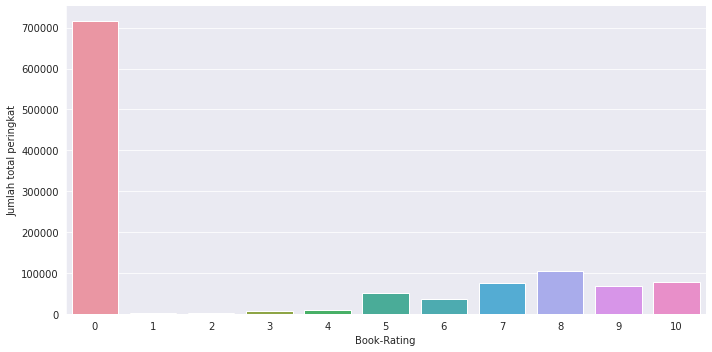

In [13]:
# plot
with sns.axes_style('darkgrid'):
    g = sns.catplot("Book-Rating", data=ratings, aspect=2.0, kind='count')
    g.set_ylabels("Jumlah total peringkat")

banyak buku yang masih memiliki rating 0, maka data tersebut dapat dihapus dengan tujuan mengurangi bias pada proses analisis

### **3.2.3 Users**

karakteristik data user

In [14]:
users = pd.read_csv('Users.csv')
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


Perlu dilakukan handling missing value pada kolom age dalam proses data preparation.

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


# **4. Persiapan Data (*Data Preparation*)**

### **4.1 Books**

menyeleksi fitur yang diperlukan

In [16]:
buku = books[['ISBN', 'Book-Title','Book-Author', 'Publisher']]
buku.head()

,ISBN,Book-Title,Book-Author,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,W. W. Norton &amp; Company


In [17]:
# cek missing value
buku.isnull().sum()

ISBN           0
Book-Title     0
Book-Author    1
Publisher      2
dtype: int64

In [18]:
# mengisi data kosong pada publisher dan author
buku.loc[:,'Book-Author'] = buku['Book-Author'].fillna('Unknown')
buku.loc[:,'Publisher'] = buku['Publisher'].fillna('Unknown')
buku.isnull().sum()

ISBN           0
Book-Title     0
Book-Author    0
Publisher      0
dtype: int64

### **4.2 Ratings**

menyeleksi fitur yang diperlukan

In [19]:
rating = ratings
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [20]:
print('Jumlah rating 0 :', rating['Book-Rating'].eq(0).sum())
rating.shape

Jumlah rating 0 : 716109


(1149780, 3)

In [21]:
# menghapus data rating 0

rating = rating[ratings['Book-Rating']>0]
rating.shape

(433671, 3)

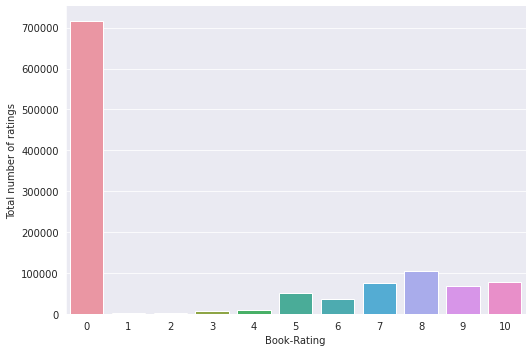

In [22]:
# plot
with sns.axes_style('darkgrid'):
    g = sns.catplot("Book-Rating", data=ratings, aspect=1.5, kind='count')
    g.set_ylabels("Total number of ratings")

### **4.2 Users**

menyeleksi fitur yang diperlukan

In [23]:
user = users
user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [24]:
# mengisi missing value dengan moduse dari Age
user['Age'] = user['Age'].fillna(user['Age'].mode())
user.isnull().sum()

User-ID          0
Location         0
Age         110761
dtype: int64

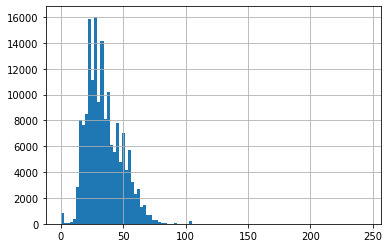

In [25]:
user['Age'].hist(bins=100)

In [26]:
# menggabungkan data buku dan rating
rating_buku = pd.merge(rating, buku, on=['ISBN'],)
rating_buku.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday


# **5. Modelling**

## **5.1 Popularity based recommendation**

merekomendasikan buku paling populer berdasarkan rata rata rating dan jumlah rating yang diterima

### **5.1.1 berdasarkan rata-rata rating**

In [27]:
rata_rating_buku = rating_buku.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False)
rata_rating_buku

ISBN
034017420X    10.0
0821414534    10.0
0821225987    10.0
0821226665    10.0
0821226703    10.0
              ... 
1903933145     1.0
0324041594     1.0
0789725134     1.0
1857975065     1.0
0061082066     1.0
Name: Book-Rating, Length: 149836, dtype: float64

terdapat lebih dari 20000 buku yang memiliki rating tertinggi, sehingga kita tidak bisa merekomendasikan 10 buku terbaik hanya berdasarkan rata-rata rating saja

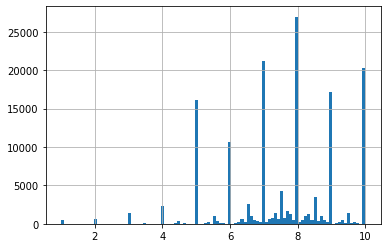

In [28]:
rata_rating_buku.hist(bins=100)

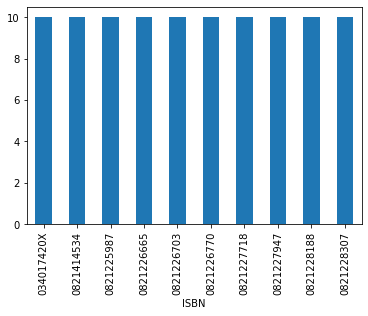

In [29]:
rata_rating_buku.head(10).plot(kind='bar')

### **5.1.2 berdasarkan jumlah peringkat yang diterima** 

# diperlukan informasi lain untuk merekomendasikan buku terbaik, disini akan digunakan jumlah rating yang diterima tiap buku

In [30]:
# recommend dari rating yang diterima
buku_populer = rating_buku.groupby('ISBN')['Book-Rating'].count().sort_values(ascending=False)
buku_populer

ISBN
0316666343    707
0971880107    581
0385504209    487
0312195516    383
0060928336    320
             ... 
0553100165      1
0553100130      1
0553099817      1
0553099809      1
B000234N3A      1
Name: Book-Rating, Length: 149836, dtype: int64

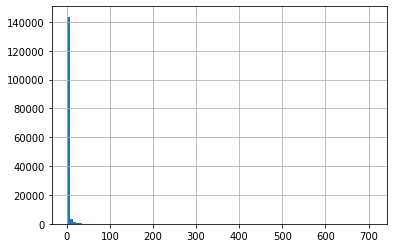

In [31]:
buku_populer.hist(bins=100)

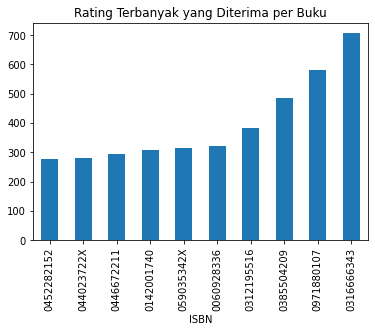

In [32]:
buku_populer.head(10).sort_values().plot(kind='bar', title='Rating Terbanyak yang Diterima per Buku')

### **5.1.3 Weighted rating**


digunakan untuk menggabungkan kedua informasi yaitu berdasarkan rata-rata rating dan jumlah rating diterima, kemudian akan dipilih 10 produk



In [33]:
rekomen_populer = pd.concat([rata_rating_buku, buku_populer],
                                   axis=1, join='inner',
                                   keys=['Average Rating', 'Rating Received'])

In [34]:
v = rekomen_populer['Rating Received'] # jumlah rating diterima
R = rekomen_populer['Average Rating'] # rata-rata rating per produk
C = rekomen_populer['Average Rating'].mean() # rata-rata rating seluruh produk
m = rekomen_populer['Rating Received'].quantile(0.75) # minimal jumlah rating yang diterima

rekomen_populer['Weighted Rating'] = ((R*v)+(C*m))/(v+m)
rekomen_populer = rekomen_populer.sort_values('Weighted Rating', ascending=False)
rekomen_populer.head(10)

,Average Rating,Rating Received,Weighted Rating
ISBN,,,
0439425220,9.869565,23,9.682203
1888054557,10.000000,11,9.619622
0836213319,9.923077,13,9.603672
0618002235,9.720000,25,9.557596
0060256656,9.750000,20,9.547958
0394800893,10.000000,8,9.505509
0394800389,9.785714,14,9.503443
1571456988,10.000000,7,9.450565
089471838X,10.000000,7,9.450565


In [35]:
# hasil rekomendasi

judul_populer = pd.merge(rekomen_populer, books[['ISBN', 'Book-Title']],
                         on='ISBN')
judul_populer = judul_populer[['Weighted Rating', 'Book-Title']]
judul_populer = judul_populer.drop_duplicates('Book-Title').set_index('Book-Title')
judul_populer.head(10)

,Weighted Rating
Book-Title,
Harry Potter and the Chamber of Secrets Postcard Book,9.682203
Postmarked Yesteryear: 30 Rare Holiday Postcards,9.619622
Dilbert: A Book of Postcards,9.603672
"The Two Towers (The Lord of the Rings, Part 2)",9.557596
The Giving Tree,9.547958
The Sneetches and Other Stories,9.505509
Fox in Socks (I Can Read It All by Myself Beginner Books),9.503443
Uncle John's Supremely Satisfying Bathroom Reader (Uncle John's Bathroom Reader),9.450565
Natural California: A Postcard Book,9.450565


## **5.2 Collaborative filtering (model based) recommendation**

Merekomendasikan buku lain kepada user yang memberi rating buku

In [36]:
rating_user = rating_buku
rating_user

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday
...,...,...,...,...,...,...
383837,276688,0425156737,2,Graven Images,Jane Waterhouse,Berkley Publishing Group
383838,276688,0671563149,6,MUDDY WATER (Peter Bartholomew Mysteries),Sally Gunning,Pocket
383839,276688,1575660792,7,Gray Matter,Shirley Kennett,Kensington Publishing Corporation
383840,276704,0380796155,5,White Abacus,Damien Broderick,Eos


### **Label encoding**

encoder User ID dan Book Title

In [37]:
le = LabelEncoder()
rating_user['UserID'] = le.fit_transform(rating_user['User-ID'])
rating_user['TitleID'] = le.fit_transform(rating_user['Book-Title'])
rating_user.drop('User-ID', axis=1, inplace=True)
rating_user

,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
0,0155061224,5,Rites of Passage,Judith Rae,Heinle,67541,84140
1,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,67542,46362
2,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press,67542,97833
3,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday,67543,3064
4,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday,2719,3064
...,...,...,...,...,...,...,...
383837,0425156737,2,Graven Images,Jane Waterhouse,Berkley Publishing Group,67537,43523
383838,0671563149,6,MUDDY WATER (Peter Bartholomew Mysteries),Sally Gunning,Pocket,67537,63876
383839,1575660792,7,Gray Matter,Shirley Kennett,Kensington Publishing Corporation,67537,43547
383840,0380796155,5,White Abacus,Damien Broderick,Eos,67538,131513


## **6. Pengembangan Model**

Mentraining data user buku dengan model SVD dari library surprise dan mengevaluasi dengan 10-fold cross validation menggunakan matriks RMSE dan MAE.

Validasi silang 10 kali lipat akan melakukan prosedur pemasangan sebanyak sepuluh kali, dengan masing-masing pemasangan dilakukan pada set pelatihan yang terdiri dari 90% dari total set pelatihan yang dipilih secara acak, dengan 10% sisanya digunakan sebagai set penahan untuk validasi.

10 fold CV adalah salah satu K fold CV yang direkomendasikan untuk pemilihan model terbaik karena cenderung memberikan estimasi akurasi yang kurang bias dibandingkan dengan CV biasa, leave-one-out CV dan bootstrap.

In [38]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_user[['UserID', 'TitleID', 'Book-Rating']],
                            reader)
svd = SVD(verbose=False, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.6307  1.6388  1.6393  1.6312  1.6371  1.6376  1.6414  1.6460  1.6372  1.6501  1.6389  0.0056  
MAE (testset)     1.2628  1.2686  1.2693  1.2609  1.2661  1.2675  1.2667  1.2706  1.2696  1.2733  1.2675  0.0035  
Fit time          13.54   12.89   17.73   12.81   13.00   12.86   12.94   12.92   12.73   13.13   13.45   1.44    
Test time         0.37    0.59    0.51    0.66    0.74    0.41    0.78    0.61    0.47    0.66    0.58    0.13    


{'fit_time': (13.536639213562012,
  12.888691902160645,
  17.730122566223145,
  12.80651593208313,
  12.997690439224243,
  12.863590002059937,
  12.940323829650879,
  12.917957782745361,
  12.733799457550049,
  13.128747463226318),
 'test_mae': array([1.26282593, 1.26856121, 1.26931319, 1.26086506, 1.26611039,
        1.26745886, 1.26666355, 1.27058822, 1.26961388, 1.2733418 ]),
 'test_rmse': array([1.63066978, 1.63876284, 1.63927667, 1.63115113, 1.63705437,
        1.63757476, 1.64139446, 1.64599225, 1.63723657, 1.65008258]),
 'test_time': (0.365429162979126,
  0.5853135585784912,
  0.5054576396942139,
  0.6556687355041504,
  0.742617130279541,
  0.4127955436706543,
  0.7764570713043213,
  0.6143038272857666,
  0.47205209732055664,
  0.658301830291748)}

## **Merekomendasikan buku berdasarkan riwayat rating user**

prediksi rating buku dengan model SVD

In [39]:
def user_recommendation(userid):
    user = rating_user[['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'TitleID']]
    user = user.reset_index()
    # getting full dataset
    data = Dataset.load_from_df(rating_user[['UserID','TitleID','Book-Rating']], reader)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    user['Estimate_Score'] = user['TitleID'].apply(lambda x: svd.predict(userid, x).est)
    user = user.drop(['index','TitleID'], axis = 1)
    user = user.sort_values('Estimate_Score' , ascending = False)
    counts1 = user['Estimate_Score'].value_counts()
    user = user[user['Estimate_Score'].isin(counts1[counts1 == 1].index)]
    return user.head(10)

In [40]:
# mencari user yang menyukai buku David Copperfield sebagai contoh
rating_user[rating_user['Book-Title'].str.contains('David Copperfield')]

,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
118262,0140430083,3,The Personal History of David Copperfield (Pen...,Charles Dickens,Penguin Books,2367,113562
118263,0140430083,8,The Personal History of David Copperfield (Pen...,Charles Dickens,Penguin Books,29423,113562
118264,0140430083,10,The Personal History of David Copperfield (Pen...,Charles Dickens,Penguin Books,60430,113562
127504,0192835785,6,David Copperfield (Oxford World's Classics),Charles Dickens,Oxford University Press,2719,25598
149078,185326024X,5,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,2719,25602
149079,185326024X,5,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,8384,25602
149080,185326024X,8,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,31752,25602
149081,185326024X,8,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,35507,25602
149082,185326024X,7,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,45309,25602
149083,185326024X,6,David Copperfield (Wordsworth Classics),Charles Dickens,NTC/Contemporary Publishing Company,53558,25602


In [41]:
user_id = 10089
print('Rating buku dari user :')
rating_user[rating_user['UserID'].eq(user_id)]

Rating buku dari user :


,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
27341,0385498802,8,Bee Season: A Novel,Myla Goldberg,Anchor Books/Doubleday,10089,12078
44787,2253140872,9,L'Ecume Des Jours,Boris Vian,Distribooks Inc,10089,56579
51924,2070375161,5,La Ferme Des Animaux,George Orwell,Gallimard French,10089,57282
89670,0061073628,9,A Night Without Armor : Poems,Jewel,Perennial Currents,10089,3036
167376,0140481346,7,Death of A Salesman,Arthur Miller,Penguin USA (Paper),10089,26496
225892,0060512377,7,Does She or Doesn't She?,Alisa Kwitney,Avon Trade,10089,30136
225896,0061058262,7,"The Crow: Clash by Night (The Crow, No 3)",Chet Williamson,Perennial Currents,10089,102531
225898,0345417127,10,The Crow: Shattered Lives &amp; Broken Dreams,J. O'Barr,Del Rey Books,10089,102533
225899,0425157415,8,"Vampires, Wine and Roses",John Richard Stephens,Berkley Publishing Group,10089,127583
225900,225303598X,8,L'histoire sans fin,Ende M.,LGF,10089,56736


In [42]:
print('Rekomendasi buku yang mungkin disukai user')
user_recommendation(user_id)

Rekomendasi buku yang mungkin disukai user


,ISBN,Book-Title,Book-Author,Publisher,Estimate_Score
357860,0373871430,"Husband To Hold (Love Inspired, No 136)",Cheryl Wolverton,Steeple Hill,8.111522
382316,0970583605,Richer Than King Tut : The Mental Game of Weal...,Lela Hayes,World Prosperity Publishing,8.083559
235661,8432043753,Como Cazar a UN Naturalista Aficionado/How to ...,Gerald Durrell,Planeta Pub Corp,8.079724
355120,0671700278,DEEP SECRETS: NANCY DREW FILES #50 (A SUMMER O...,Carolyn Keene,Simon Pulse,8.076270
382995,3442453852,Hurenkind,Christine Gran,Distribooks Inc,8.074864
67761,0906138213,"Lent and Eastertide (In Conversation with God,...",Francis Fernandez,"Scepter Publishers, Inc.",8.066238
316461,0590137743,Fade to Black (Point Crime S.),Stan Nicholls,Scholastic Point,8.060410
224922,0812575733,Border Crossings,Carole Bellacera,Forge Books,8.055868
128797,0340784989,"You're a Disgrace, Daisy (Definitely Daisy)",Jenny Oldfield,Hodder Children's Books,8.051003
288166,0316848727,New England Wilds,Ogden Tanner,Little Brown &amp; Company,8.049062
